### Note

Repository
https://github.com/Wikar235/disease-recognition

Project
https://github.com/users/Wikar235/projects/2

Data
https://www.kaggle.com/datasets/lokisilvres/dental-disease-panoramic-detection-dataset

### Load Data

#### Image download

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lokisilvres/dental-disease-panoramic-detection-dataset")

/Users/syatsuzuka/.pyenv/versions/3.12.9/envs/test-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!tree $path -d

/Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6
├── COCO
│   └── COCO
│       ├── annotations
│       ├── test
│       ├── train
│       └── valid
└── YOLO
    └── YOLO
        ├── test
        │   ├── images
        │   └── labels
        ├── train
        │   ├── images
        │   └── labels
        └── valid
            ├── images
            └── labels

18 directories


#### Listing up image files

##### Training data

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

image_extensions = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp']
count_train = 0
files_train = []
files_train_labels = []

for root, dirs, files in os.walk(path+"/YOLO/YOLO/train"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            count_train += 1
            files_train.append(os.path.join(root, file))
            files_train_labels.append(os.path.join(root.replace('/images', '/labels'), os.path.splitext(file)[0] + '.txt'))

##### Test data

In [4]:
count_test = 0
files_test = []
files_test_labels = []

for root, dirs, files in os.walk(path+"/YOLO/YOLO/test"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            count_test += 1
            files_test.append(os.path.join(root, file))
            files_test_labels.append(os.path.join(root.replace('/images', '/labels'), os.path.splitext(file)[0] + '.txt'))

##### Validation data

In [5]:
count_valid = 0
files_valid = []
files_valid_labels = []

for root, dirs, files in os.walk(path+"/YOLO/YOLO/valid"):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            count_valid += 1
            files_valid.append(os.path.join(root, file))
            files_valid_labels.append(os.path.join(root.replace('/images', '/labels'), os.path.splitext(file)[0] + '.txt'))

#### Sample Image check

0 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/train/images/3585150000-jpg_png_jpg.rf.45c5a7e150f53076399c33479c775ab8.jpg
Image shape: (640, 640, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/train/images/3832840000-jpg_png_jpg.rf.917a84a8314fc4b44f3ffec2be024915.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
2 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/train/images/9ca39105-MORTAJI_SAEIDEH_2020-06-16104607_jpg.rf.c7fed91c49456945ae346784f51b2e16.jpg
Image shape: (840, 1615, 3)
Image data type: uint8
Min pixel value: 0
Max pixel value: 255
3 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6

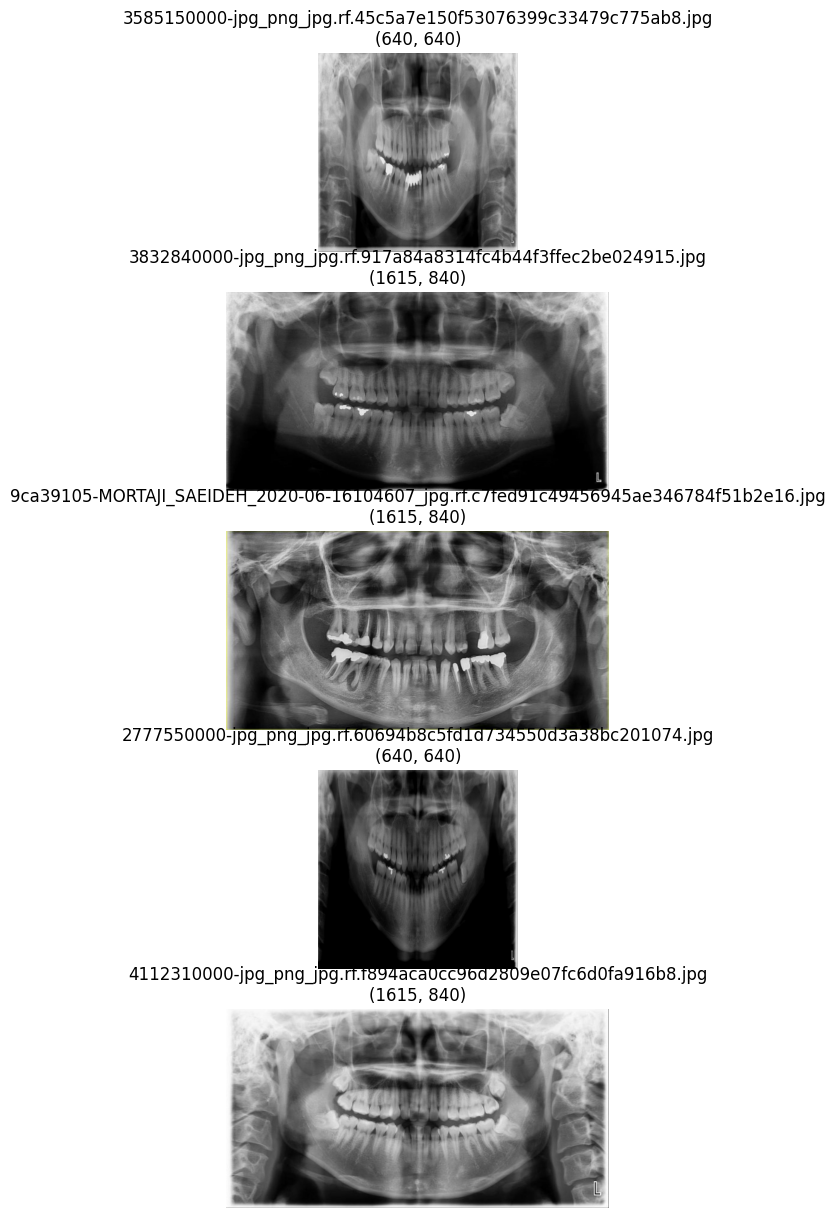

In [6]:
plt.figure(figsize=(20, 15))
img = []

for i, img_file in enumerate(files_train):
    if (i >= 5):
        break

    print(i, img_file)
    img.append(Image.open(os.path.join(root, img_file)))
    numpy_array_pil = np.array(img[i])

    print("Image shape:", numpy_array_pil.shape)
    print("Image data type:", numpy_array_pil.dtype)
    print("Min pixel value:", numpy_array_pil.min())
    print("Max pixel value:", numpy_array_pil.max())

    plt.subplot(5, 1, i+1)
    plt.imshow(img[i], cmap='gray' if img[i].mode == 'L' else None)
    plt.title(f"{os.path.basename(img_file)}\n{img[i].size}")
    plt.axis('off')

##### Loading training data

In [7]:
X_train = []

for i, img_file in enumerate(files_train):
    img = Image.open(os.path.join(root, img_file))
    X_train.append(np.array(img))


##### Loading test data

In [8]:
X_test = []

for i, img_file in enumerate(files_test):
    img = Image.open(os.path.join(root, img_file))
    X_test.append(np.array(img))

Loading validation data

In [9]:
X_valid = []

for i, img_file in enumerate(files_valid):
    img = Image.open(os.path.join(root, img_file))
    X_valid.append(np.array(img))

### Read labels

In [10]:
def read_coco_labels(label_file, img_width, img_height):

    labels = []

    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # skip invalid line
                class_id, x_center, y_center, w, h = map(float, parts)

                x_center_abs = x_center * img_width
                y_center_abs = y_center * img_height
                w_abs = w * img_width
                h_abs = h * img_height

                labels.append([class_id, x_center_abs, y_center_abs, w_abs, h_abs])

    return np.array(labels)

In [11]:
def read_yolo_polygon(label_file, img_width, img_height):

    polygons = []

    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))
                points = [(coords[i] * img_width, coords[i+1] * img_height)
                          for i in range(0, len(coords), 2)]
                polygons.append((class_id, points))

    # print("label_file:", label_file)

    # for polygon in polygons:
    #     print("Polygon class_id:", polygon[0], ", # of points:", len(polygon[1]), ", Points:", polygon[1])

    return polygons

In [12]:
label_path = path+"/YOLO/YOLO/train/labels"

all_labels = []

for i, img_file in enumerate(files_train):
    base_name = os.path.basename(img_file)
    name_no_ext = os.path.splitext(base_name)[0]
    label_file = os.path.join(label_path, name_no_ext + '.txt')

    # Check if label file exists
    if not os.path.exists(label_file):
        all_labels.append(np.array([]))  # append empty array for this image
        continue

    # Get image size
    img_obj = Image.open(img_file)
    width, height = img_obj.size

    # Read labels
    labels = read_yolo_polygon(label_file, width, height)
    all_labels.append(labels)


#### Check a sample labels

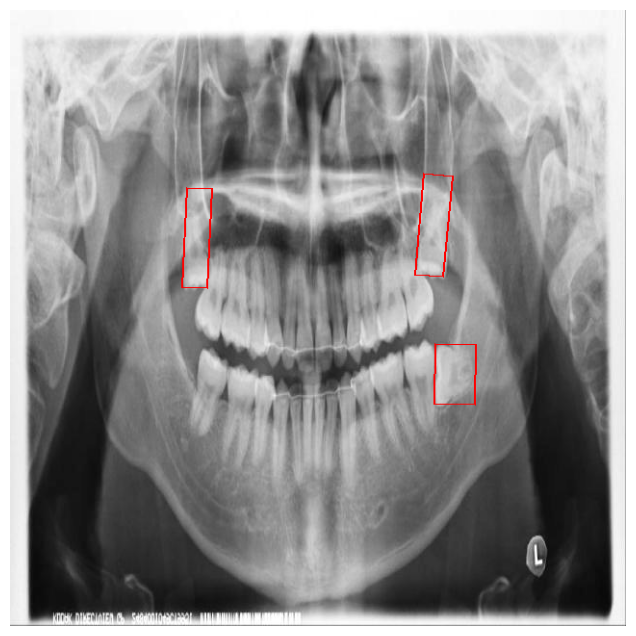

In [13]:
# Open image
index = 50

img = Image.open(files_train[index])
width, height = img.size

# Read polygons from its label
if os.path.exists(files_train_labels[index]):
    polygons = read_yolo_polygon(files_train_labels[index], width, height)
else:
    print("Label file does not exist:", files_train_labels[index])
    polygons = []

# Draw polygons
draw = ImageDraw.Draw(img)
for class_id, points in polygons:
    draw.polygon(points, outline="red", width=2)
    # for x, y in points:
    #     draw.ellipse((x-2, y-2, x+2, y+2), fill="blue")

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.show()

### Load Yolo model

In [14]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
pt_file = path+"/best.pt"
# pt_file = "yolo11n-seg.pt"
model = YOLO(pt_file)

# Display model information (optional)
# model.info()

# Train the model on the COCO8 example dataset for 100 epochs
# yaml_file = path + "/YOLO/YOLO/data.yaml"
# results = model.train(data=yaml_file, epochs=1, imgsz=640)

### Yolo Prediction

#### Best Model

YOLOv8x-seg summary: 243 layers, 65,255,261 parameters, 0 gradients, 298.3 GFLOPs

image 1/1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/test/images/4089280000-jpg_png_jpg.rf.df7df8f64f726034b18a9aee518a087d.jpg: 640x640 3 Fillings, 4 impacted tooths, 618.1ms
Speed: 4.3ms preprocess, 618.1ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)


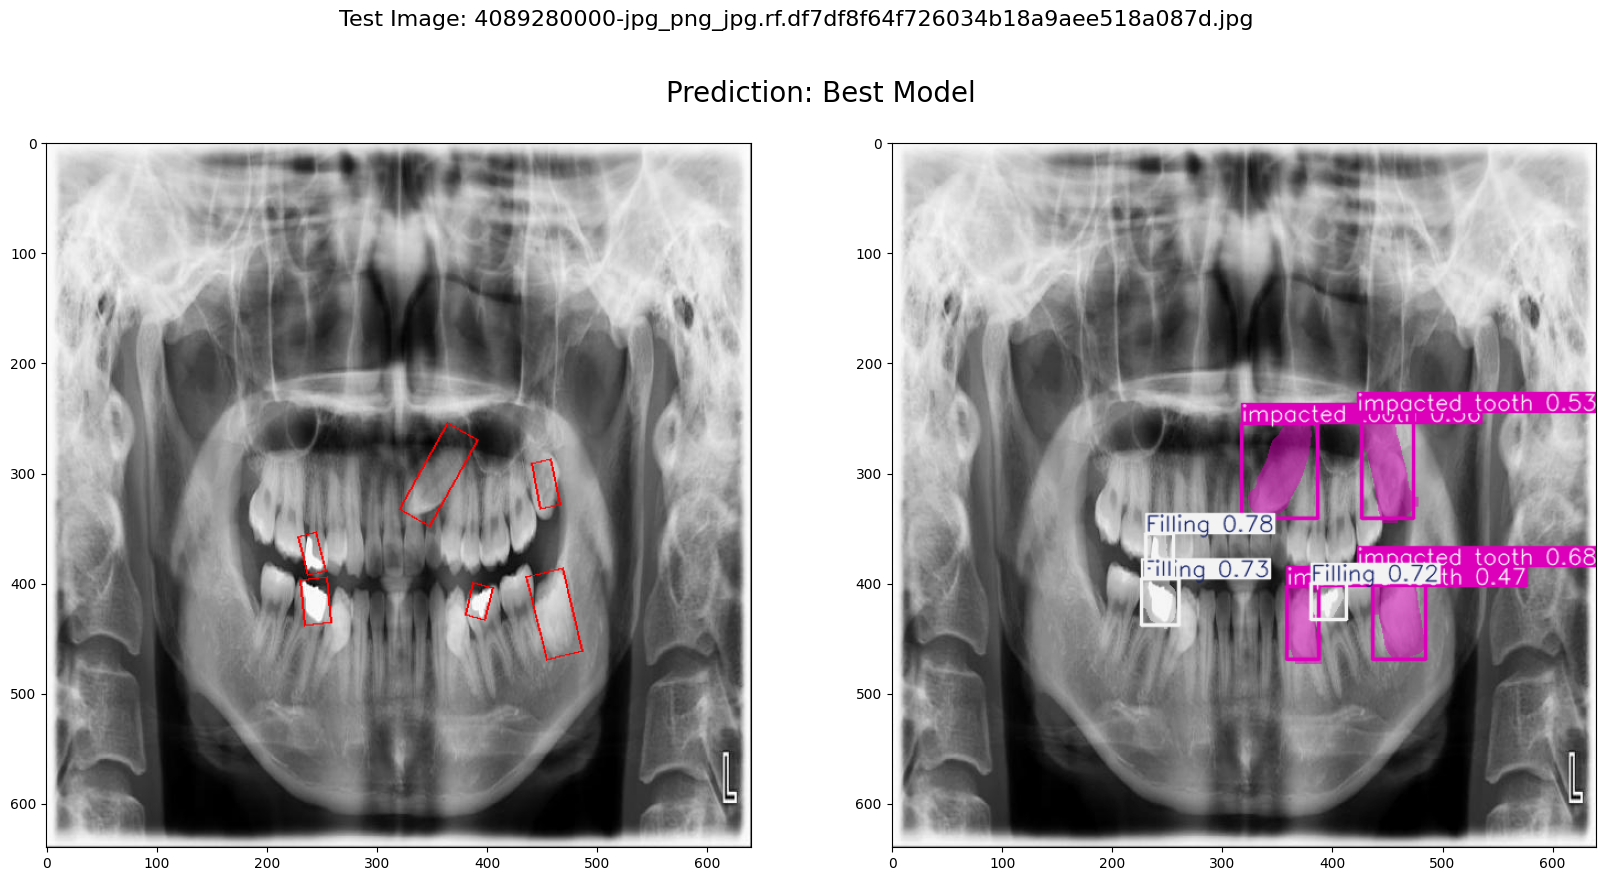

In [15]:

from ultralytics import YOLO
import cv2


#===== Choose a sample image =====
index = 210
test_image = files_test[index]
test_image_label = files_test_labels[index]

#===== Show the Test Image =====
img = Image.open(test_image)
width, height = img.size

polygons = read_yolo_polygon(test_image_label, width, height)
draw = ImageDraw.Draw(img)
for class_id, points in polygons:
    draw.polygon(points, outline="red", width=2)

#===== Loading a model =====
pt_file = path+"/best.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_5epoch.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_100epoch.pt"
model = YOLO(pt_file)
model.info()

#===== Prediction =====
results = model.predict(test_image)
plotted_img = results[0].plot()


#===== Show Prediction Result =====
plt.figure(figsize=(20, 10))
plt.suptitle(f"Test Image: {os.path.basename(test_image)}", fontsize=16)
plt.title(f"Prediction: Best Model", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))

### Custom Model (5 epoch)

YOLO11n-seg summary: 203 layers, 2,848,653 parameters, 0 gradients, 9.8 GFLOPs

image 1/1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/test/images/4089280000-jpg_png_jpg.rf.df7df8f64f726034b18a9aee518a087d.jpg: 416x416 3 Fillings, 3 impacted tooths, 35.0ms
Speed: 2.3ms preprocess, 35.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


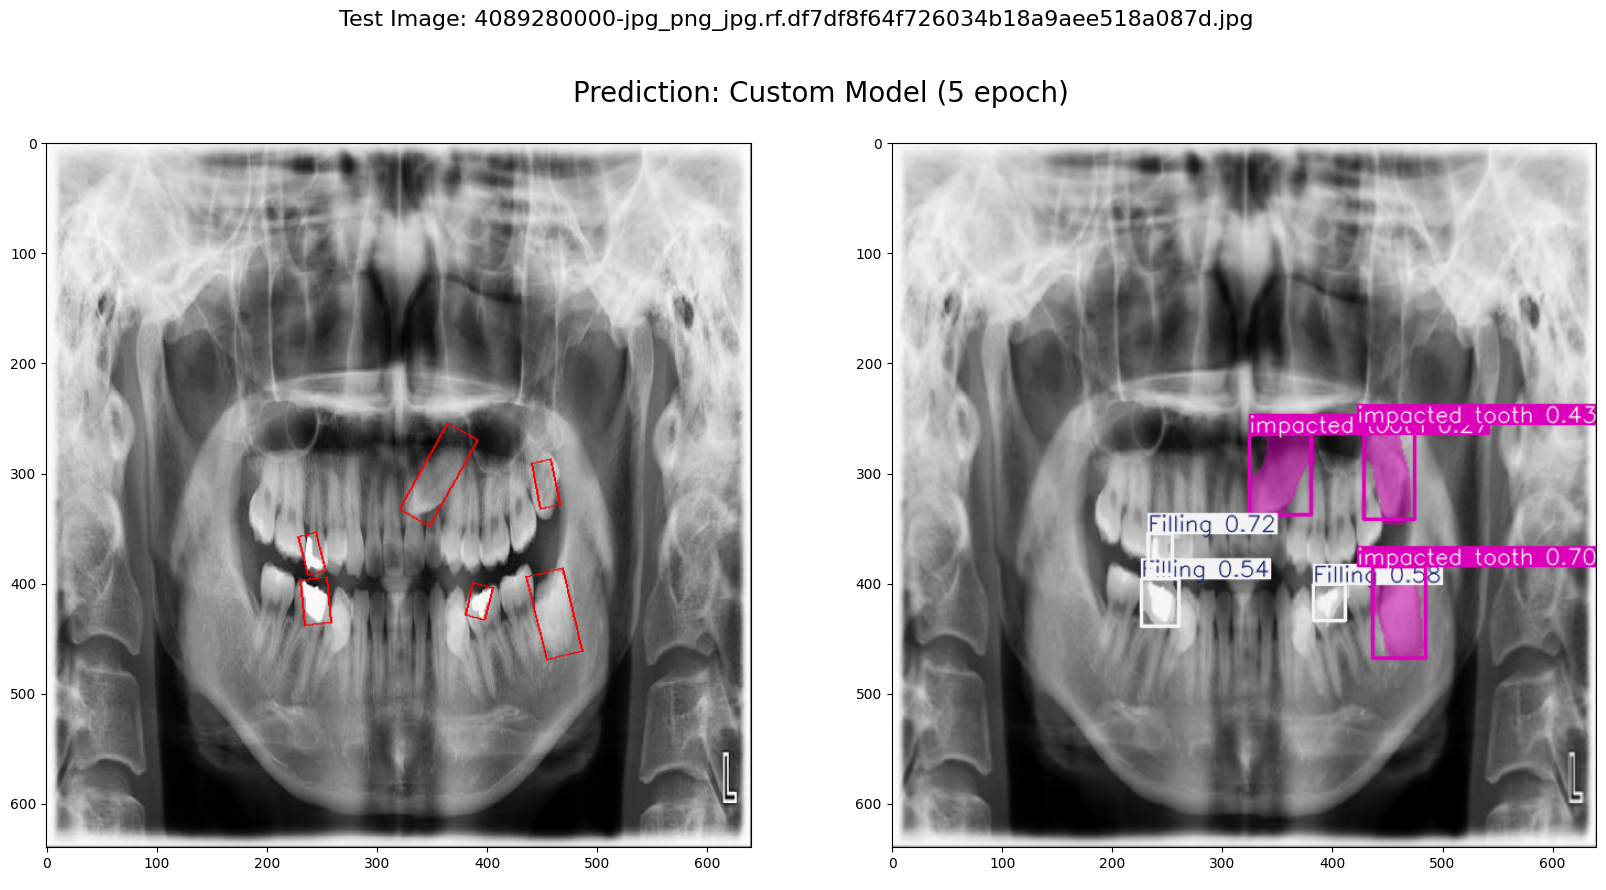

In [16]:

from ultralytics import YOLO
import cv2


#===== Choose a sample image =====
index = 210
test_image = files_test[index]
test_image_label = files_test_labels[index]

#===== Show the Test Image =====
img = Image.open(test_image)
width, height = img.size

polygons = read_yolo_polygon(test_image_label, width, height)
draw = ImageDraw.Draw(img)
for class_id, points in polygons:
    draw.polygon(points, outline="red", width=2)

#===== Loading a model =====
# pt_file = path+"/best.pt"
pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_5epoch.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_100epoch.pt"
model = YOLO(pt_file)
model.info()

#===== Prediction =====
results = model.predict(test_image)
plotted_img = results[0].plot()


#===== Show Prediction Result =====
plt.figure(figsize=(20, 10))
plt.suptitle(f"Test Image: {os.path.basename(test_image)}", fontsize=16)
plt.title(f"Prediction: Custom Model (5 epoch)", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))

### Custom Model (100 epoch)

YOLO11n-seg summary: 203 layers, 2,848,653 parameters, 0 gradients, 9.8 GFLOPs

image 1/1 /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/YOLO/YOLO/test/images/4089280000-jpg_png_jpg.rf.df7df8f64f726034b18a9aee518a087d.jpg: 416x416 4 Fillings, 3 impacted tooths, 39.5ms
Speed: 2.1ms preprocess, 39.5ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


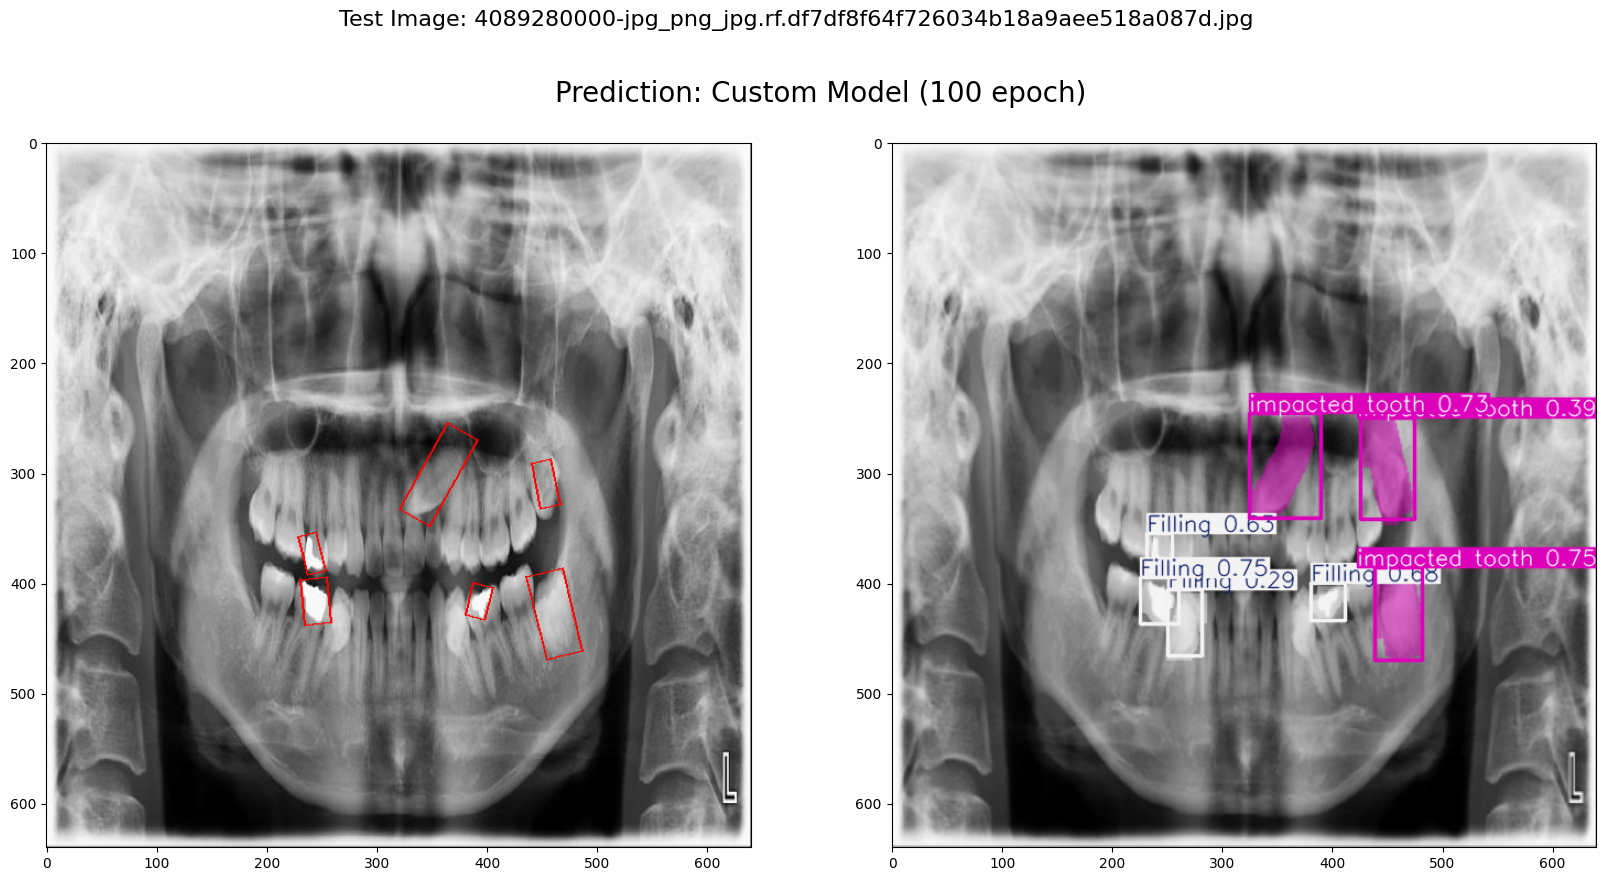

In [17]:

from ultralytics import YOLO
import cv2


#===== Choose a sample image =====
index = 210
test_image = files_test[index]
test_image_label = files_test_labels[index]

#===== Show the Test Image =====
img = Image.open(test_image)
width, height = img.size

polygons = read_yolo_polygon(test_image_label, width, height)
draw = ImageDraw.Draw(img)
for class_id, points in polygons:
    draw.polygon(points, outline="red", width=2)

#===== Loading a model =====
# pt_file = path+"/best.pt"
# pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_5epoch.pt"
pt_file = "/Users/syatsuzuka/code/Wikar235/disease-recognition/models/trained_model_100epoch.pt"
model = YOLO(pt_file)
model.info()

#===== Prediction =====
results = model.predict(test_image)
plotted_img = results[0].plot()


#===== Show Prediction Result =====
plt.figure(figsize=(20, 10))
plt.suptitle(f"Test Image: {os.path.basename(test_image)}", fontsize=16)
plt.title(f"Prediction: Custom Model (100 epoch)", fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))

### Evaluating model

#### Best Model

In [18]:
!pwd

/Users/syatsuzuka/code/Wikar235/disease-recognition/notebooks


=== YOLO Validation Script ===
Model: /home/shunjiro/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6/best.pt
Batch size: 12
Image size: 420
Device: cuda
Path to dataset files: /home/shunjiro/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6
/home/shunjiro/.pyenv/versions/test2-env/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
mAP@0.5: 0.27287493046926387
mAP@0.5:0.95: 0.1413280827789592
Precision: 0.4744010257016747
Recall: 0.3825157405630011



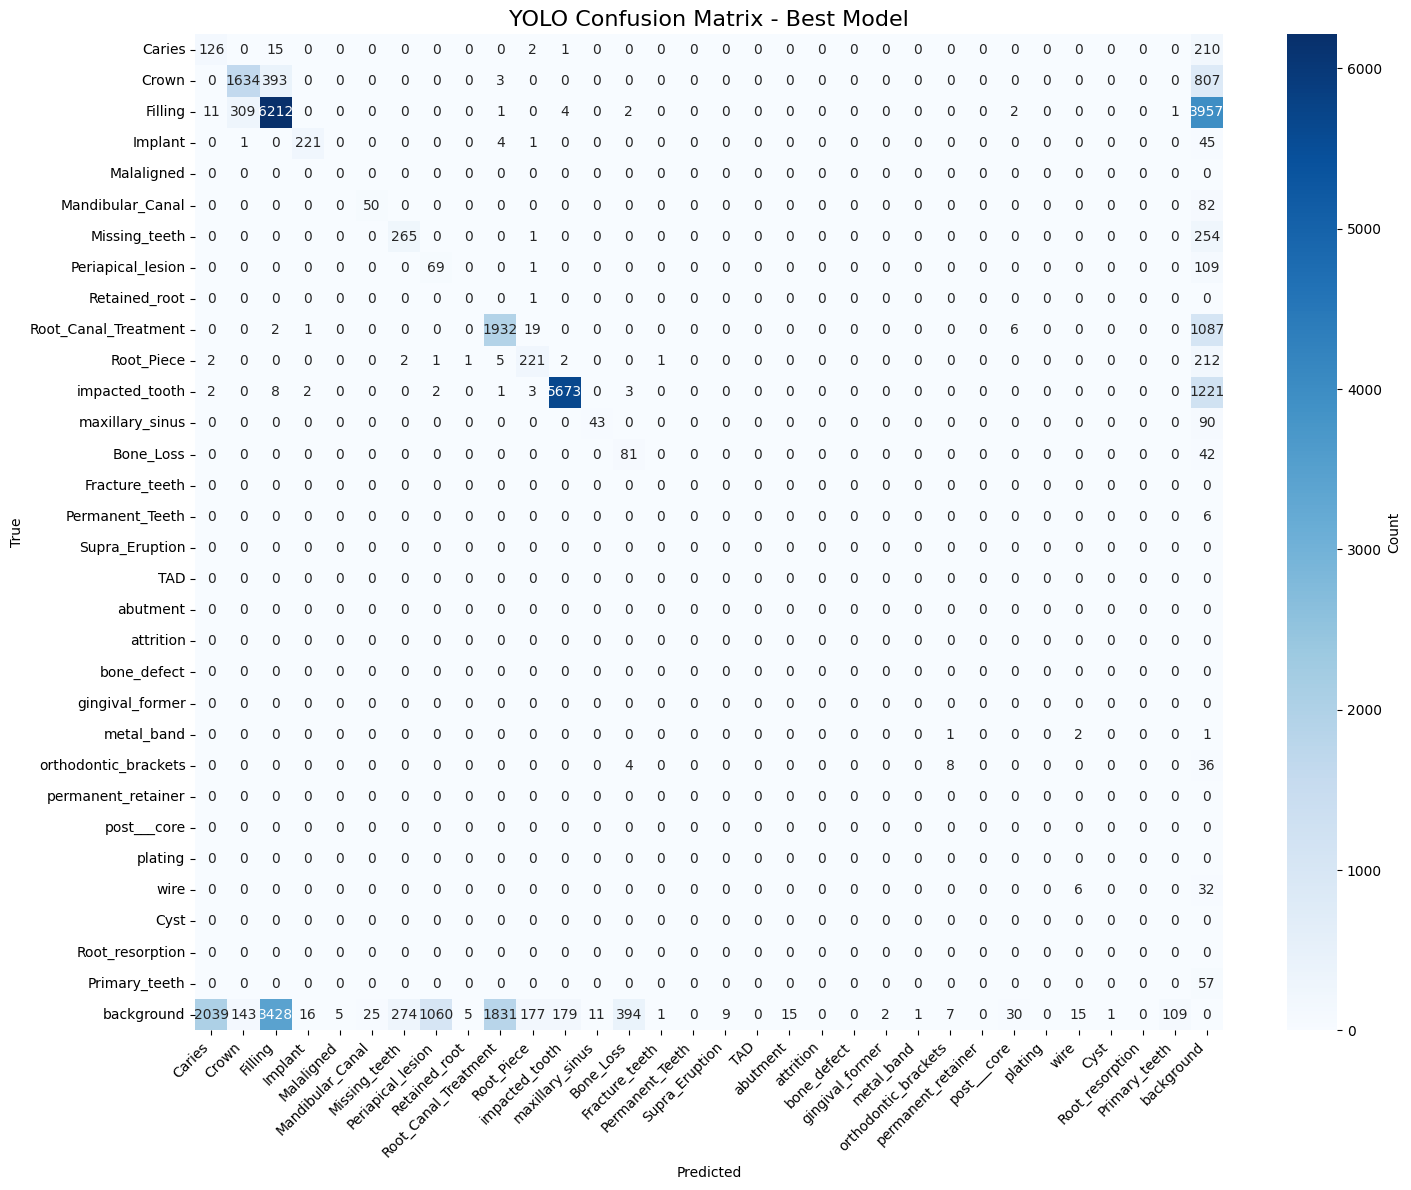

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_raw = pd.read_csv("../models/best.pt.val.csv")

df = df_raw.set_index('Predicted')
df = df.drop('Unnamed: 0', axis=1)

df = df.astype(float).fillna(0).astype(int)

#===== Print Confusion Matrix =====
with open("../models/best.pt.val.log", 'r', encoding='utf-8') as f:
    content = f.read()
    print(content)

#===== Plot Confusion Matrix =====
plt.figure(figsize=(15, 12))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Count'})
plt.title('YOLO Confusion Matrix - Best Model', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Custom Model (5 epochs)

=== YOLO Validation Script ===
Model: ../models/trained_model.pt
Batch size: 12
Image size: 420
Device: cpu
Path to dataset files: /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6
mAP@0.5: 0.19475141100811352
mAP@0.5:0.95: 0.09740300659582134
Precision: 0.2754885197148844
Recall: 0.2725472135617654



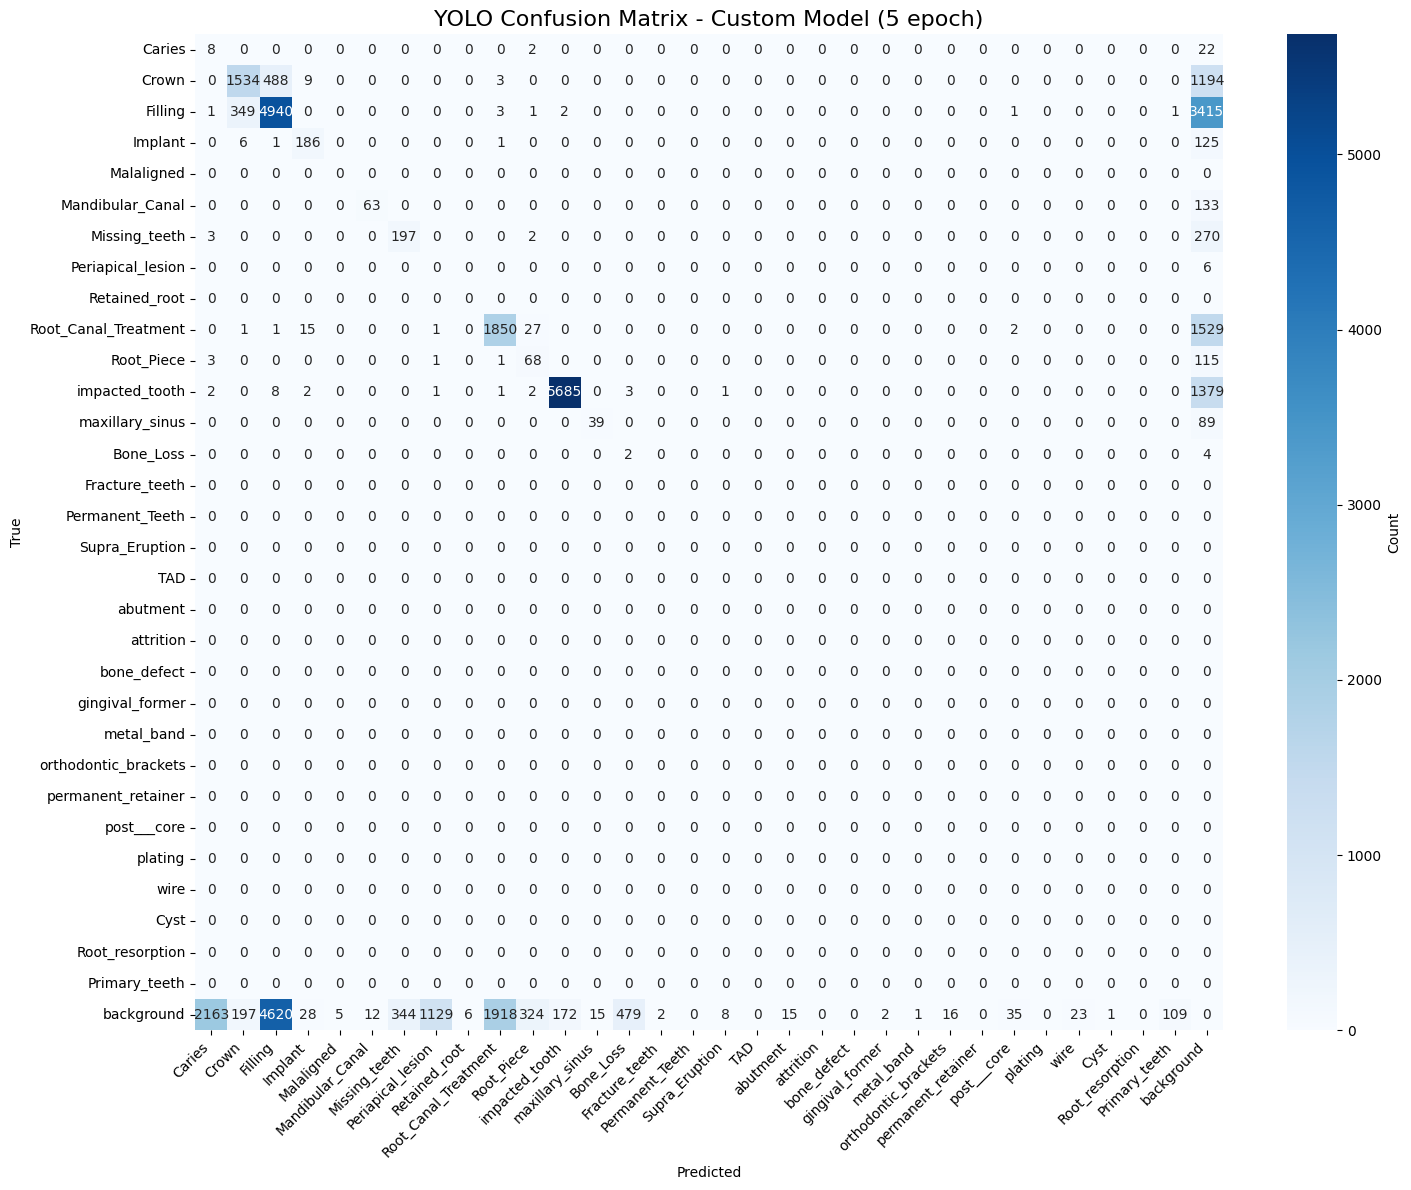

In [ ]:
df_raw = pd.read_csv("../models/trained_model_5epoch.pt.val.csv")

df = df_raw.set_index('Predicted')
df = df.drop('Unnamed: 0', axis=1)

df = df.astype(float).fillna(0).astype(int)

#===== Print Confusion Matrix =====
with open("../models/trained_model_5epoch.pt.val.log", 'r', encoding='utf-8') as f:
    content = f.read()
    print(content)

#===== Plot Confusion Matrix =====

plt.figure(figsize=(15, 12))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Count'})
plt.title('YOLO Confusion Matrix - Custom Model (5 epoch)', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Custom Model (100 epochs)

=== YOLO Validation Script ===
Model: ../models/trained_model_100epoch.pt
Batch size: 12
Image size: 420
Device: cpu
Path to dataset files: /Users/syatsuzuka/.cache/kagglehub/datasets/lokisilvres/dental-disease-panoramic-detection-dataset/versions/6
mAP@0.5: 0.33464146684168017
mAP@0.5:0.95: 0.16426859384899958
Precision: 0.37172181111066066
Recall: 0.42344592097455674



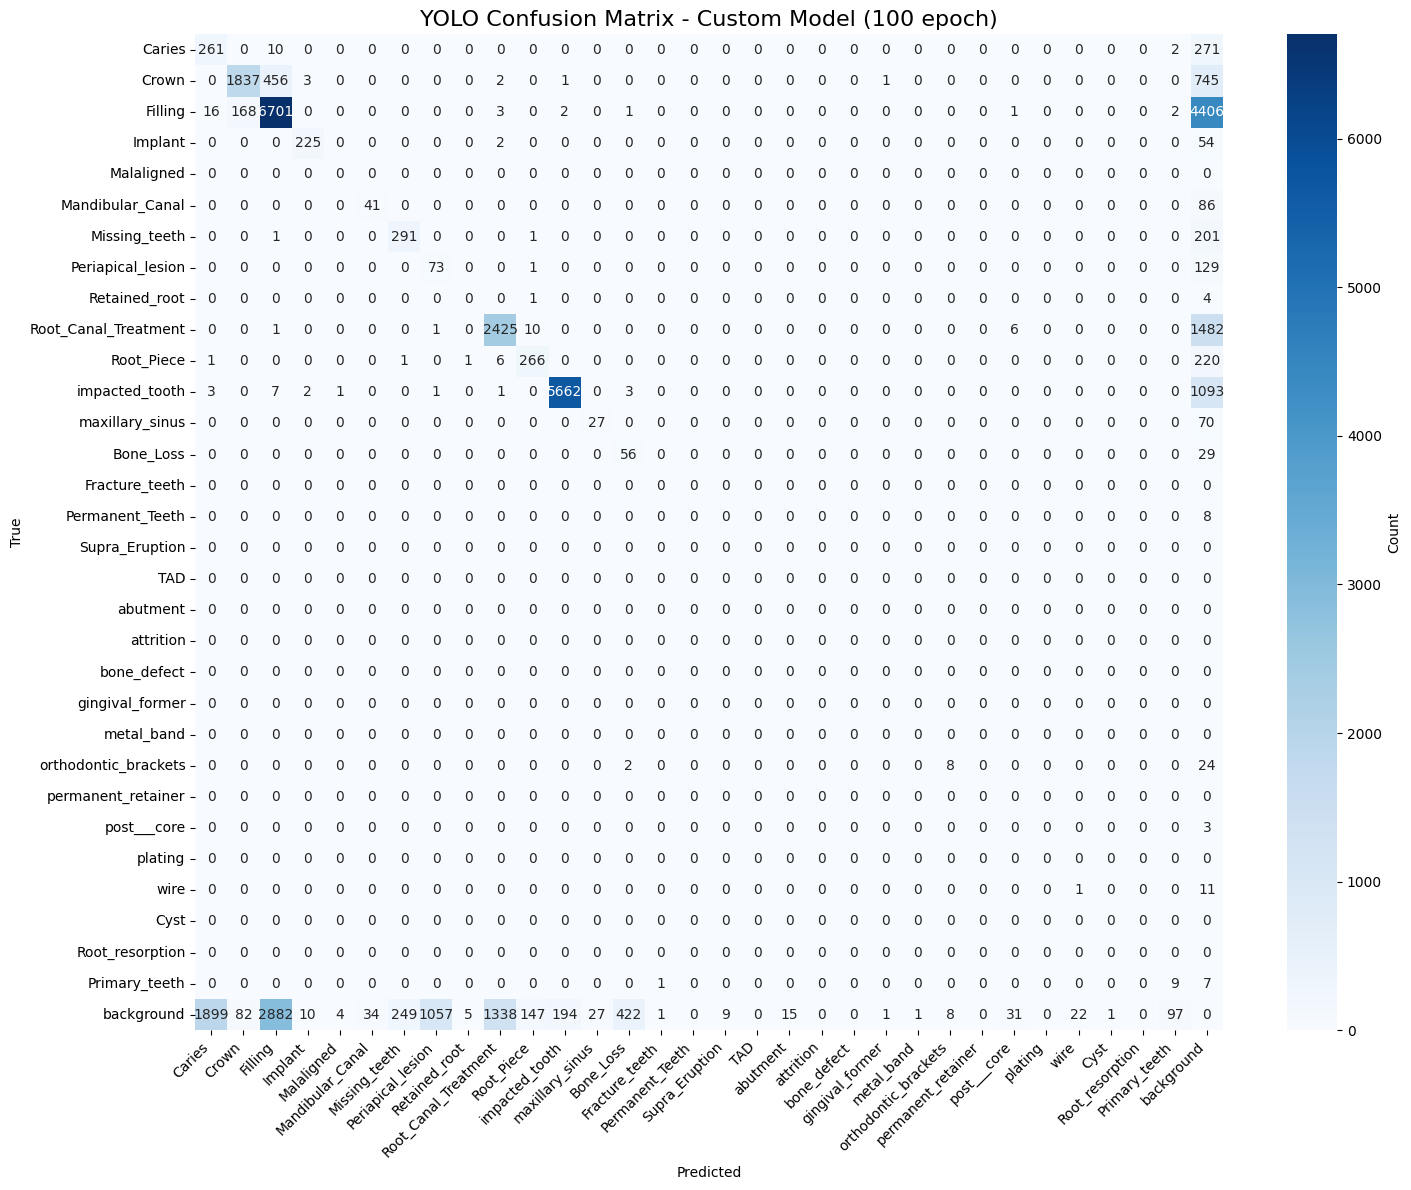

In [ ]:
df_raw = pd.read_csv("../models/trained_model_100epoch.pt.val.csv")

df = df_raw.set_index('Predicted')
df = df.drop('Unnamed: 0', axis=1)

df = df.astype(float).fillna(0).astype(int)

#===== Print Confusion Matrix =====
with open("../models/trained_model_100epoch.pt.val.log", 'r', encoding='utf-8') as f:
    content = f.read()
    print(content)

#===== Plot Confusion Matrix =====

plt.figure(figsize=(15, 12))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Count'})
plt.title('YOLO Confusion Matrix - Custom Model (100 epoch)', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()